In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy.stats
import scipy.optimize
import numdifftools as nd
from numdifftools import Jacobian, Hessian
sns.set()

In [2]:
pd.set_option('precision', 2)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [3]:
# BYMARKEDER
#df = pd.read_csv("https://raw.githubusercontent.com/Oliverkobaek/thesis_2020/master/Bresnahan/by%20markeder/Bresnahan_data_by.csv")

# KOMMUNEMARKEDER
df = pd.read_csv("https://raw.githubusercontent.com/Oliverkobaek/thesis_2020/master/Bresnahan/Bresnahan_data_full_l%C3%A6s%C3%B8.csv")

df = df.drop(['Unnamed: 0'], axis=1)

In [4]:
df

,Kommune,ALDER,d65,d17,samlet_ind,Besk,Besk1864,DK,Befolkning,markedsvaerdix,yderkom,antal_apo,År
0,101,36.10,0.11,0.17,197499.87,0.55,0.73,0.79,518574,2068229.73,0,26,2008
1,147,39.68,0.16,0.17,221333.09,0.54,0.76,0.85,95029,2206108.69,0,5,2008
2,151,40.04,0.18,0.23,186155.49,0.49,0.77,0.88,47398,2432344.50,0,3,2008
3,153,40.57,0.18,0.22,172691.88,0.48,0.73,0.76,33762,1951806.28,0,2,2008
4,155,42.38,0.20,0.23,220357.76,0.51,0.82,0.94,13411,2977526.41,0,1,2008
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1073,825,51.74,0.35,0.14,154652.82,0.47,0.73,0.93,1795,789854.05,1,0,2014
1074,825,51.80,0.36,0.14,156511.19,0.47,0.74,0.92,1817,547791.16,1,0,2015
1075,825,52.28,0.37,0.13,158750.32,0.47,0.75,0.92,1793,489477.15,1,0,2016
1076,825,52.95,0.38,0.13,165000.49,0.48,0.75,0.91,1807,570316.13,1,0,2017


In [5]:
# df['Befolkning'] betyder at det er på kommuneniveau - er det korrekt?
df['receptgrænse'] = 270000*1.02317**(df['År']-2011)

år = list(range(2008,2019))
# vi har indsat 0 i år efter 2015 for at sikre at disse markeder ikke er restrikteret
gnsrecept = [13.1, 13.12, 13.19, 13.13, 13.24, 13.26, 13.53, 13.13, 0 ,0 ,0]
gnsreceptdic = {}
for i in range(len(gnsrecept)):
    gnsreceptdic[år[i]] = gnsrecept[i]
    
restriction = []

for år in range(2008,2019):
    liste = list((df['Befolkning'][df['År']==år]*gnsreceptdic[år]-df['receptgrænse'][df['År']==år]*df['antal_apo'][df['År']==år])>=df['receptgrænse'][df['År']==år])
    for i in liste:
        restriction.append(i)
        
df['restriction'] = restriction

In [6]:
## FIX YDERKOMMUNER ##
df_komkode_yder = pd.read_excel('kommunerkoderyder.xlsx')
df = df.merge(df_komkode_yder, on = "Kommune")
df  = df.drop('yderkom', axis = 1)
df = df.rename(columns={'Yderkommuner':'yderkom'})

In [7]:
df['yder_mono'] = ((df['antal_apo']<=1)* (df['yderkom']==1))
df['yder_mono'] = df['yder_mono'].astype(int)

C:\Users\Oliver\Anaconda3\lib\site-packages\pandas\core\computation\expressions.py:178: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


In [8]:
# KOMMUNER
df['logbefolkning'] = df['Befolkning']/1000#df['By_befolkning']/1000

# BYMARKEDER
#df['logbefolkning'] = df['By_befolkning']/1000#


###
df['logmarkedsvalue'] = df['markedsvaerdix']/100000 #np.log()
df['logindkomst'] = df['samlet_ind']/100000 #np.log()

# Unrestricted markets
#df = df[df['restriction']==True]

In [9]:
# for 3 alpha 3 gamma
def V(df, Ni, alpha=np.ones(3), beta=np.ones(6)):
    """Per-capita variable profit
    
    df: data
    Ni: number of incumbents in market i
    alpha: alpha parameters
    beta: beta parameter
    """
    n = np.min([3, Ni])
#     n = Ni
    a = 0
    for i in range(1,n):
        a = a + alpha[i]
    

    Z = np.c_[df.d65, df.d17, df.logindkomst, df.Besk1864, df.DK, df.yder_mono]# np.log() 

    # W = df.LANDV
    # X = np.c_[W, Z]

    X = np.c_[Z]
    
    
    profit = alpha[0] + X @ beta - a
    return profit

def F(df, Ni, gamma=np.ones(3)):
    n = np.min([3, Ni])
#     n = Ni
    g = 0
    # gamma 2 through gamma 5 (indices 1 through 4)
    for i in range(1,n):
        g = g + gamma[i]

    fixed_cost = gamma[0] + gamma[3]*df.logmarkedsvalue + g
    return fixed_cost

#def S_func(df, lam):
def S_func(df, lam): #, lam
    S =   lam * df.logbefolkning #np.log() #
    return S

#def neg_log_lik(theta=np.ones(19), market='TIRE', df=None):
def neg_log_lik(theta=np.ones(15), market='antal_apo', df=df):#, df=None):
    lam = theta[0]
    beta = theta[1:7]
    alpha = theta[7:10]
    gamma = theta[10:14]
#    beta = theta[0:5]
#    alpha = theta[5:10]
#    gamma = theta[10:16]
    
    
    Phi = scipy.stats.norm.cdf
    
    S = S_func(df, lam) #, lam

    
    P = [0] * 4
    Pi_bar = lambda N: S * V(df, N, alpha=alpha, beta=beta) - F(df, N, gamma=gamma)
    P[0] = np.log( 1 - Phi(Pi_bar(0)) )
    P[3] = np.log( Phi(Pi_bar(3)) )
    for i in range(1,3):
        P[i] = np.log( Phi(Pi_bar(i)) - Phi(Pi_bar(i+1)) )

        
    for i in range(4):
        P[i][P[i] == -np.inf] = -100000000
    log_lik = 0 
    for i in range(3):
        log_lik = log_lik + np.sum(P[i] * (df[market] == i))
    log_lik = log_lik + np.sum(P[3] * (df[market] >= 3))
    return -log_lik


def theta_to_param_dict(theta):
    lam = theta[0]
    beta = theta[1:7]
    alpha = theta[7:10]
    gamma = theta[10:14]
#    beta = theta[0:5]
#    alpha = theta[5:10]
#    gamma = theta[10:16]
    
    
    d = {'lam': lam, 'beta': beta, 'alpha': alpha, 'gamma': gamma, 'theta': theta} 
    return d

In [10]:
theta0 = np.ones(14) * 0.1
neg_log_lik(df=df, theta=theta0)

C:\Users\Oliver\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: RuntimeWarning: divide by zero encountered in log
C:\Users\Oliver\Anaconda3\lib\site-packages\ipykernel_launcher.py:65: RuntimeWarning: divide by zero encountered in log


1412.9339445795033

In [11]:
df = df.sample(frac=1, random_state = 1).reset_index(drop=True)

In [12]:
%%time
ba = [-np.inf] * 7
bb = [0] * 6
lower_bounds = [*ba, *bb, -np.inf]
upper_bounds = [np.inf] * 14
bounds = list(zip(lower_bounds, upper_bounds))


theta0 = np.ones(14) * 0.1
nll = lambda theta: neg_log_lik(theta=theta, df=df)
out = scipy.optimize.minimize(nll, theta0, bounds=bounds,
    options={'disp': False, 'maxiter': 10000}
    )

C:\Users\Oliver\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: RuntimeWarning: divide by zero encountered in log
C:\Users\Oliver\Anaconda3\lib\site-packages\ipykernel_launcher.py:65: RuntimeWarning: divide by zero encountered in log


Wall time: 1min 37s


In [13]:
out

      fun: 510.8724489563757
 hess_inv: <14x14 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.03726655,  0.00374598, -0.31262744,  0.29218654,  0.1462297 ,
        0.29755256, -0.03468585,  0.09895871, -0.161549  , -0.13462795,
        0.06637606,  2.47706566, -0.0080604 , -0.32237608])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 9450
      nit: 530
   status: 0
  success: True
        x: array([ 0.99786732,  0.21566052, -0.2956122 , -0.01152913, -0.04752299,
        0.10946946, -0.86007164,  1.76049585,  1.67743144,  0.00290787,
        2.52675181,  0.        ,  1.46707754, -0.01004234])

In [14]:
N = len(df) #Korriger så det passer til antal observationer. 
test = out.hess_inv.todense()/N
se3 = np.sqrt(np.diag(test))
se3

array([3.86454628, 0.61573488, 1.34913219, 0.11159463, 0.03455762,
       0.28935144, 0.14816195, 1.04081019, 0.70407031, 0.0800281 ,
       4.89392011, 0.03045725, 1.38060838, 0.08393056])

In [15]:
Hfun = nd.Hessian(nll, full_output=True)
hessian_nd, info= Hfun(out['x'])
se = np.sqrt(np.diag(np.linalg.inv(hessian_nd)))
results = pd.DataFrame({'parameters':out['x'],'std err':se, "std err diag":se3})
results.index=['lambda - befolkning','beta_1 - d65','beta_2 - d17','beta_3 - indkomst','beta_4 - besk','beta_5 - Foreigner', 'beta_6 - yderkom', 'alpha_1','alpha_2','alpha_3','gamma_1','gamma_2','gamma_3', 'gamma_6 - Landvalue'] #,'gamma6'  ,
results

C:\Users\Oliver\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: RuntimeWarning: divide by zero encountered in log
C:\Users\Oliver\Anaconda3\lib\site-packages\ipykernel_launcher.py:65: RuntimeWarning: divide by zero encountered in log
C:\Users\Oliver\Anaconda3\lib\site-packages\ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in log
C:\Users\Oliver\Anaconda3\lib\site-packages\ipykernel_launcher.py:65: RuntimeWarning: invalid value encountered in log


,parameters,std err,std err diag
lambda - befolkning,1.00,21.18,3.86
beta_1 - d65,0.22,4.58,0.62
beta_2 - d17,-0.30,6.21,1.35
beta_3 - indkomst,-0.01,0.24,0.11
beta_4 - besk,-0.05,0.95,0.03
beta_5 - Foreigner,0.11,2.30,0.29
beta_6 - yderkom,-0.86,13.01,0.15
alpha_1,1.76,31.74,1.04
alpha_2,1.68,30.06,0.70
alpha_3,0.00,0.04,0.08


In [16]:
hat_theta = theta_to_param_dict(out.x)

In [17]:
hat_theta

{'lam': 0.9978673235750053,
 'beta': array([ 0.21566052, -0.2956122 , -0.01152913, -0.04752299,  0.10946946,
        -0.86007164]),
 'alpha': array([1.76049585, 1.67743144, 0.00290787]),
 'gamma': array([ 2.52675181,  0.        ,  1.46707754, -0.01004234]),
 'theta': array([ 0.99786732,  0.21566052, -0.2956122 , -0.01152913, -0.04752299,
         0.10946946, -0.86007164,  1.76049585,  1.67743144,  0.00290787,
         2.52675181,  0.        ,  1.46707754, -0.01004234])}

In [18]:
def calcS(df, theta):
    d = theta_to_param_dict(theta)
    S_grid = np.zeros(5)
    
    dfm = df.mean()
    for i in range(5):
        n = i + 1
        S_grid[i] = F(dfm, n, d['gamma']) / V(dfm, n, d['alpha'], d['beta'])
        print(F(dfm, n, d['gamma']) )
        print(V(dfm, n, d['alpha'], d['beta']))
    return S_grid

S_vals = calcS(df, out.x)

2.3893030396528525
[1.74775668]
2.3893030396528525
[0.07032524]
3.8563805786508865
[0.06741737]
3.8563805786508865
[0.06741737]
3.8563805786508865
[0.06741737]


In [19]:
table5A_left = pd.DataFrame({'Apoteker':S_vals}).T
table5A_left.columns = ['S_1', 'S_2', 'S_3', 'S_4', 'S_5']
table5A_left

,S_1,S_2,S_3,S_4,S_5
Apoteker,1.37,33.98,57.20,57.20,57.20


In [20]:
a = [S_vals[i+1]/S_vals[i] * ((i+1)/(i+2)) for i in range(4)]
table5A_right = pd.DataFrame(a).T
table5A_right.columns = ['s2/s1', 's3/s2', 's4/s3', 's5/s4']
table5A_right

,s2/s1,s3/s2,s4/s3,s5/s4
0,12.43,1.12,0.75,0.80


In [21]:
SN_S5_ratio = S_vals[5-1]* np.arange(1,5+1) / (S_vals * 5)

In [22]:
SN_S5_ratio 

array([8.36850346, 0.67345419, 0.6       , 0.8       , 1.        ])

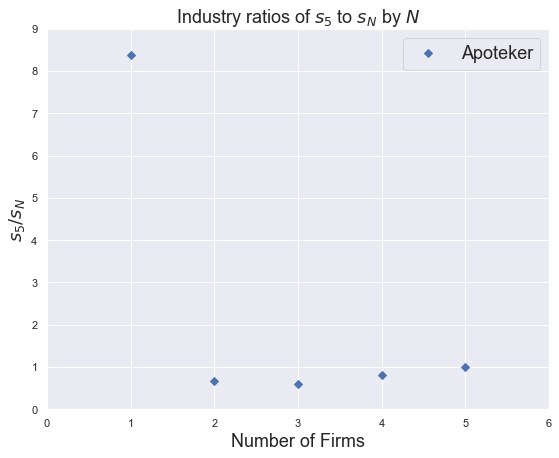

In [23]:
BIG = 18
fig = plt.figure(figsize=(9,7))
plt.plot([1,2,3,4,5], SN_S5_ratio, 'D', label='Apoteker')
ax = fig.get_axes()[0]
plt.legend(fontsize=BIG)
plt.xlim(0,6)
plt.ylim(0.0, 9)
plt.title('Industry ratios of $s_5$ to $s_N$ by $N$', fontsize=BIG)
plt.xlabel('Number of Firms', fontsize=BIG)
plt.ylabel('$s_5/s_N$', fontsize=BIG);
# ax.set_ylabel('$s_5/s_N$', fontsize=40)